In [2]:
import os
# os.environ["HTTP_PROXY"] = "http://appaccess-zscaler.boehringer.com:80"
# os.environ["HTTPS_PROXY"] = "https://appaccess-zscaler.boehringer.com:443"
# os.environ["NO_PROXY"] = "127.0.0.1,10.0.0.0/8,localhost,boehringer.com,eu.boehringer.com,am.boehringer.com"
# os.environ["http_proxy"] = "http://appaccess-zscaler.boehringer.com:80"
# os.environ["https_proxy"] = "https://appaccess-zscaler.boehringer.com:443"
# os.environ["no_proxy"] = "127.0.0.1,10.0.0.0/8,localhost,boehringer.com,eu.boehringer.com,am.boehringer.com"

import sys

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# import pyhive
import numpy as np
import seaborn as sns

import statsmodels
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# import jupyterthemes
# import jaydebeapi
# import getpass
import datetime

from datetime import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

from pandas.tseries.offsets import DateOffset

In [3]:


#######################################
############## FRONTLINE ##############
#######################################

Frontline_invoice = pd.read_csv('Data//Frontline_channel_sku.csv') # where is the data?

Frontline_invoice = Frontline_invoice.pivot_table(index = 'Date', columns = 'SKU', aggfunc = 'sum')['COGS_QTY'] # pivot table
Frontline_invoice = Frontline_invoice.reset_index()

Frontline_invoice['Date'] = Frontline_invoice['Date'].apply(lambda x: datetime(int(x//100), int(x%100), 1)) # what's the format of date?
Frontline_invoice = Frontline_invoice.set_index('Date')

Frontline_invoice.columns = [str(int(x)) for x in Frontline_invoice.columns] # reset column name

# where is the data?
Frontline_JDA = pd.read_csv('Data//Frontline_JDA.csv')
mapping = pd.read_csv('Data//SKU_descroption_mapping.csv')
Frontline_2021 = pd.read_csv('Data//Frontline_channel_sku_2020-2021.csv')

## map the channel
# channel_mapping = {'Buying Group':'Corp Accounts',
# 'Catalog':'Gen Vet',
# 'Distributor all Ranges':'Gen Vet',
# 'Distributor Companion Animal':'Gen Vet',
# 'Distributor Large Animal':'Gen Vet',
# 'Fleet Store':'Gen Vet',
# 'General Veterinarian':'Gen Vet',
# 'Government':'Gen Vet',
# 'Internal Customer':'Gen Vet',
# 'Military':'Gen Vet',
# 'Mobile Vet':'Retail',
# np.nan:'Gen Vet',
# 'National Hospital Organization':'Corp Accounts',
# 'Non-Merial':'Gen Vet',
# 'Pharmacy':'Gen Vet',
# 'Retail Customer':'Retail',
# 'Shelter':'Gen Vet',
# 'SSO':'Corp Accounts',
# 'University':'Gen Vet',
# 'Veterinary School':'Gen Vet',
# 'Customer Warehouse':'Gen Vet'}

# Frontline_invoice['channel_group'] = Frontline_invoice['channel'].apply(lambda x: channel_mapping[x])

In [ ]:
Data = pd.read_csv('C:\\Users\\qintong\\Desktop\\Pet GTN Forecast\\Working Folder\\Data\\pet_units_sales.csv') # where is data?

Sku_data = Data.pivot_table(index = ['Date'], columns = ['sku_code'], aggfunc = 'sum' )[['gross_sales', 'cog_qty']]

# Brand_data = Data.pivot_table(index = ['Date'], columns = ['prd_grp_level3'], aggfunc = 'sum' )[['gross_sales', 'cog_qty']]
SKU_qty = Sku_data['cog_qty'].reset_index().reset_index()
SKU_qty.columns = ['index', 'Date'] + [str(int(x)) for x in SKU_qty.columns[2:]]

# Nexgard_SKU_List = ['142833', '142835', '142831', '142829', '142832', '142834', '142830', '142828']
# Heartgard_SKU_LList = ['150848','150843','150849','150842','150844','150845','1508487']
Frontline_SKU_List = ['145450', '145448', '145449', '145460', '141348', '141354']

Frontline = SKU_qty[['Date'] + Frontline_SKU_List]
Frontline['Date'] = Frontline['Date'].apply(lambda x: datetime(int(x//100), int(x%100), 1))
Frontline_invoice = Frontline.set_index('Date')

In [4]:
#####################################################################################
######################## Forecast Available Data Preparation ########################
#####################################################################################

#################################################
############## Independent Varibles##############
#################################################

####################################################
####### Prepare Numerical External Variables #######
####################################################

df_ext = pd.read_csv('Data//External Variable with forecast.csv') # where is data?
df_ext['Date'] = df_ext['Date'].apply(lambda x: datetime(int(x.split('/')[2]), int(x.split('/')[0]), 1))

# df_ext = df_ext.merge(indep_var, on = 'Date', how = 'left')
# df_ext = df_ext.merge(df_market_share, on = 'Date', how = 'left')

## numerical variables
numerical_var = df_ext[['Date', 'disposable_income_pct', 'Unemployment Rate',
       'CPI_US', 'HW Risk Index', 'temperature', 'humidity', 'precip_in_mm',
       'FT Risk Index', 'Puppies', 'Adult Dogs', 'Kittens',
       'Adult Cats']]
# display(numerical_var)

## numerial variables names
num_var_name = [
    'disposable_income_pct', 'Unemployment Rate',
       'CPI_US', 'HW Risk Index', 'temperature', 'humidity', 'precip_in_mm',
       'FT Risk Index', 'Puppies', 'Adult Dogs', 'Kittens',
       'Adult Cats']

# time shift
lags = [1, 2, 3]
# Lag 1 2 3 
for var in num_var_name:
    for lag in lags:
        name = var + '_lag' + str(lag)
        #print(name)
        numerical_var[name] = numerical_var[var].shift(lag)

# time diff
# Diff 1 2 3
for var in num_var_name:
    for lag in lags:
        name = var + '_diff' + str(lag)
        numerical_var[name] = numerical_var[var].diff(lag)

# percent diff        
#pct Diff 1 2 3
for var in num_var_name:
    for lag in lags:
        name = var + '_pct_diff' + str(lag)
        numerical_var[name] = numerical_var[var].diff(lag)/numerical_var[var].shift(lag)

# Moving Average
for var in num_var_name:
    for lag in lags:
        name = var + '_ma' + str(lag)
        numerical_var[name] = numerical_var[var].rolling(window = lag).mean()
  
# #Pet/Owner Number
# pet_var = ['owner num', 'pet num']
# lags = [1 , 2 , 3]
# #Lag 1 2 3 
# for var in pet_var:
#     for lag in lags:
#         name = var + '_lag' + str(lag)
#         numerical_var[name] = numerical_var[var].shift(lag)

# #Diff 1 2 3
# for var in pet_var:
#     for lag in lags:
#         name = var + '_diff' + str(lag)
#         numerical_var[name] = numerical_var[var].diff(lag)
        
# #pct Diff 1 2 3
# for var in pet_var:
#     for lag in lags:
#         name = var + '_pct_diff' + str(lag)
#         numerical_var[name] = numerical_var[var].diff(lag)/numerical_var[var].shift(lag)

# #Moving Average
# for var in pet_var:
#     for lag in lags:
#         name = var + '_ma' + str(lag)
#         numerical_var[name] = numerical_var[var].rolling(window = lag).mean()




#Leap Shift

leaps = [-1 , -2 , -3]

leap_var = ['HW Risk Index', 'temperature', 'humidity', 'precip_in_mm',
       'FT Risk Index']
#Lag 1 2 3 
for var in leap_var:
    for leap in leaps:
        name = var + '_leap' + str(leap)
        numerical_var[name] = numerical_var[var].shift(leap)

var_list = list(numerical_var.columns[1:])

scale = StandardScaler()
numerical_var_scale = numerical_var[numerical_var['Date'].apply(lambda x: x.year > 2017)]
numerical_var_scale = numerical_var_scale.dropna()
numerical_var_scale[var_list] = scale.fit_transform(numerical_var_scale[var_list])


############################################
####### Promotion Number Categorical #######
############################################


promotion_var = df_ext[['Date', 'CENTRAGARD', 'CENTRAGARD_SINGLES', 'FRONTLINE_GOLD',
       'FRONTLINE_PLUS', 'FRONTLINE_SHIELD', 'FRONTLINE_SPRAY',
       'FRONTLINE_TRITAK', 'HEARTGARD_CHEWABLES', 'HEARTGARD_PLUS_CHEWABLES',
       'HEARTGARD_TABLETS', 'NEXGARD']]

promo_var_name = ['CENTRAGARD', 'CENTRAGARD_SINGLES', 'FRONTLINE_GOLD',
       'FRONTLINE_PLUS', 'FRONTLINE_SHIELD', 'FRONTLINE_SPRAY',
       'FRONTLINE_TRITAK', 'HEARTGARD_CHEWABLES', 'HEARTGARD_PLUS_CHEWABLES',
       'HEARTGARD_TABLETS', 'NEXGARD']


lags = [1 , 2 , 3]
#Lag 1 2 3 
for var in promo_var_name:
    for lag in lags:
        name = var + '_lag' + str(lag)
        promotion_var[name] = promotion_var[var].shift(lag)

#Diff 1 2 3
for var in promo_var_name:
    for lag in lags:
        name = var + '_diff' + str(lag)
        promotion_var[name] = promotion_var[var].diff(lag)
        
#pct Diff 1 2 3
for var in promo_var_name:
    for lag in lags:
        name = var + '_pct_diff' + str(lag)
        promotion_var[name] = promotion_var[var].diff(lag)/promotion_var[var].shift(lag)

#Moving Average
for var in promo_var_name:
    for lag in lags:
        name = var + '_ma' + str(lag)
        promotion_var[name] = promotion_var[var].rolling(window = lag).mean()



########################################
####### Price Change Categorical #######
########################################

# price_df = pd.read_csv('Data//price_df.csv')
# price_df = price_df[['Date', 'primary_brand', 'price_change']]
# price_df = price_df.pivot_table(index = ['Date'], columns = 'primary_brand')['price_change']
# price_df.columns = [x + '_pc' for x in price_df.columns]


# leaps = [-1 , -2 , -3]

# leap_var = list(price_df.columns)
# #Lag 1 2 3 
# for var in leap_var:
#     for leap in leaps:
#         name = var + '_leap' + str(leap)
#         price_df[name] = price_df[var].shift(leap)
# price_df = price_df.reset_index()

# price_df['Date'] = price_df['Date'].apply(lambda x: datetime(int(x.split('-')[0]), int(x.split('-')[1]), 1))


#external_var = numerical_var_scale.merge(price_df, on = ['Date'], how = 'left')
# external_var = numerical_var_scale.merge(promotion_var, on = ['Date'], how = 'left')
external_var = numerical_var_scale.copy()
# external_var = external_var.dropna(axis = 1)
ext_var_list = external_var.columns[1:] #Whole Independent Variable List

In [5]:
########## Add Dummy Variables ##########
for month in range(1, 13):
    external_var[str(month)] = 0
    external_var.loc[external_var['Date'].apply(lambda x: x.month == month),str(month)] = 1

In [66]:
#######################################################################
#################### Class and Function Definition ####################
#######################################################################

def forecast_plot(Actual, Insample, OutofSample, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    npre = 4
    ax.set(title=title, xlabel='Date', ylabel='Revenues')
    # Plot data points
    Actual.plot(ax=ax, style='y-o', label='Observed')

    # Plot predictions
    Insample.plot(ax=ax, style='r--o', label='In-Sample Forecast')
    # ci = predict_ci.copy()
    # ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    OutofSample.plot(ax=ax, style='g-o', label='Out of Sample Forecast')
    # ci = predict_dy_ci
    # ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

    legend = ax.legend(loc='lower right')

    forecast = pd.DataFrame(Actual)
    forecast['Insample'] = Insample
    forecast['OutofSample'] = OutofSample

    forecast.to_csv('C:\\Users\\qintong\\Desktop\\Pet GTN Forecast\\Working Folder\\result\\Frontline\\' + title + '.csv')

class model():
    def __init__(self, model):
        self.model_core = model_core
        self._forecast = forecast_fun
    def insample(self, df):
        self.insample = df

    def forecast(self, start, step):
        self._forecast 


class Demand_Forecast():
    def __init__(self, df_all, ext_var_list, start = None):
        self.df_all = df_all
        self.ext_var_list = ext_var_list

    # def train_forecast_split(self):       

    def lasso_selection(self, target, var_select = None):
        if not var_select:
            print('Lasso on Total')
            print(ext_var_list)
            y = self.df_all[target]
            X = self.df_all[ext_var_list]
        
            clf = Lasso(alpha=100).fit(X, y)

            select = (clf.coef_ > 0)
            X = X[np.asarray(X.columns)[select]]
            reg = LinearRegression().fit(X, y)

            X2 = sm.add_constant(X)
            lasso_est = sm.OLS(y, X2).fit()
        else:
            print('Lasso on Partial')
            y = self.df_all[target]
            X = self.df_all[var_select]
        
            clf = Lasso(alpha=100).fit(X, y)

            select = (clf.coef_ > 0)
            X = X[np.asarray(X.columns)[select]]
            reg = LinearRegression().fit(X, y)

            X2 = sm.add_constant(X)
            lasso_est = sm.OLS(y, X2).fit()

        return lasso_est


    def linear_regression(self, target, var_select, start, end, period):
        
        ############################################################
        ####### Variables selected based on Lasso and Pvalue #######
        ############################################################
        
        ######### Manual Adjustment #########

        df_train = self.df_all[(self.df_all.index >= start) & (self.df_all.index <= end)]
        X = df_train[var_select]
        y = df_train[target]
        reg = LinearRegression().fit(X, y)
        result = pd.DataFrame(y)
        Insample = reg.predict(X)
        X2 = sm.add_constant(X)
        est = sm.OLS(y, X2).fit()
        summary = est.summary()
        start_f = pd.to_datetime(end) +  pd.DateOffset(months = 1)
        end_f = pd.to_datetime(end) + pd.DateOffset(months = period)
        x_forecast = df_all[start_f:end_f][var_select]
        forecast = reg.predict(x_forecast)

        return est, summary, Insample, forecast

    def ARIMAX_regression_training(self, target, var_select,start, end, vanilla = [0, 0, 0] , seasonal = [0, 0, 0, 0]):
        ################################
        ######### ARIMAX Model #########
        ################################
        
        ######### Manual Adjustment #########
        df_train = self.df_all[(self.df_all.index >= start) & (self.df_all.index <= end)]
        X = df_train[var_select]
        y = df_train[target]
        X2 = sm.add_constant(X)
        
        ##### Parameter Optimization #####
        current_aic = float('inf')
        est = None
        i = 0
        total = (vanilla[0] + 1) * (vanilla[1] + 1) * (vanilla[2] + 1) * (seasonal[0] + 1) * (seasonal[1] + 1) * (seasonal[2] + 1)
        for p in range(vanilla[0] + 1):
            for d in range(vanilla[1] + 1):
                for q in range(vanilla[2] + 1):
                    for P in range(seasonal[0] + 1):
                        for D in range(seasonal[1] + 1):
                            for Q in range(seasonal[2] + 1):
                                i += 1
                                print("%.2f" % (i/total*100),'%', end='\r')
                                try:
                                    if P + D + Q == 0:
                                        mod = sm.tsa.statespace.SARIMAX(y, exog=X2, order=(p,d,q),  freq = 'MS')
                                    else:
                                        mod = sm.tsa.statespace.SARIMAX(y, exog=X2, order=(p,d,q), seasonal_order = (P, D, Q, 12),  freq = 'MS')
                                    res = mod.fit(disp=False)
                                    if res.aic < current_aic:
                                        current_aic = res.aic
                                        est = [(p, d, q), (P, D, Q, 12)]
                                except:
                                    pass
        print('****************************')
        print(est)
        ##### End Parameter Optimization #####
        return est
    def ARIMAX_regression(self, target, var_select, start, end, est, period):
        df_train = self.df_all[(self.df_all.index >= start) & (self.df_all.index <= end)]
        X_all = df_train[var_select]
        X_all = sm.add_constant(X_all)
        endog = df_train[target]
        res_all = sm.tsa.statespace.SARIMAX(endog, exog=X_all, order=est[0], seasonal_order = est[1], freq = 'MS').fit()
        # print(res_all.summary())
        predict = res_all.get_prediction()
        Insample = predict.predicted_mean[start:end]
        start_f = pd.to_datetime(end) +  pd.DateOffset(months = 1)
        end_f = pd.to_datetime(end) + pd.DateOffset(months = period)
        x_forecast = df_all[start_f:end_f][var_select]
        x_forecast = sm.add_constant(x_forecast)
        OOS = res_all.get_prediction(start = start_f, end = end_f, exog=x_forecast).predicted_mean
        # display(OOS)
        observed = self.df_all[target]
        # forecast_plot(observed, Insample, OOS, target + ' ARIMAX')
        return res_all.summary(), Insample, OOS


Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['disposable_income_pct_lag2', 'disposable_income_pct_lag3', 'CPI_US_lag1', 'humidity_lag1', 'FT Risk Index_lag1', 'Adult Cats_lag3', 'Unemployment Rate_diff3', 'HW Risk Index_diff1', 'temperature_diff2', 'CPI_US_pct_diff1', 'HW Risk Index_pct_diff3', 'temperature_pct_diff2', 'Puppies_pct_diff3', 'precip_in_mm_leap-2', '1', '2', '8']
****************************
[(0, 0, 1), (0, 0, 0, 12)]
SARIMAX Model:  0.33625122998784135


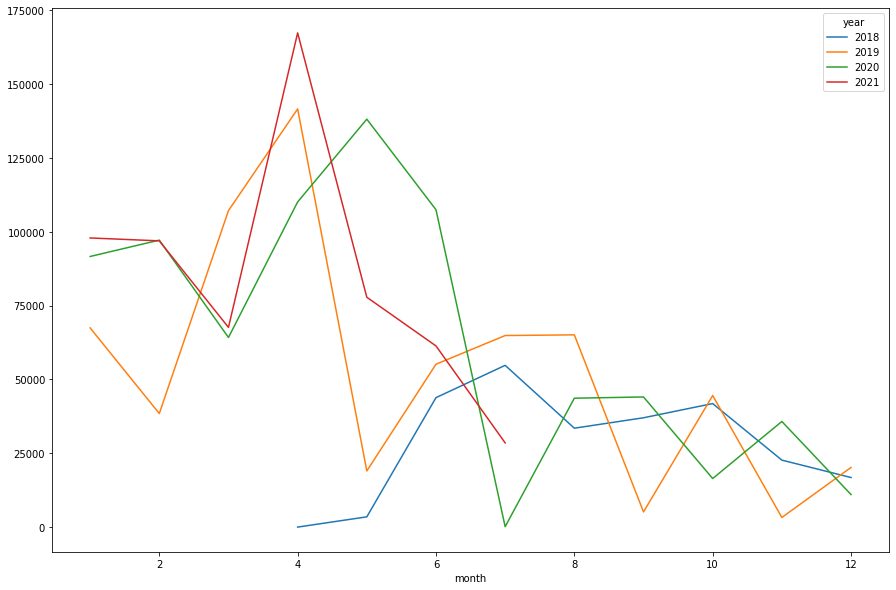

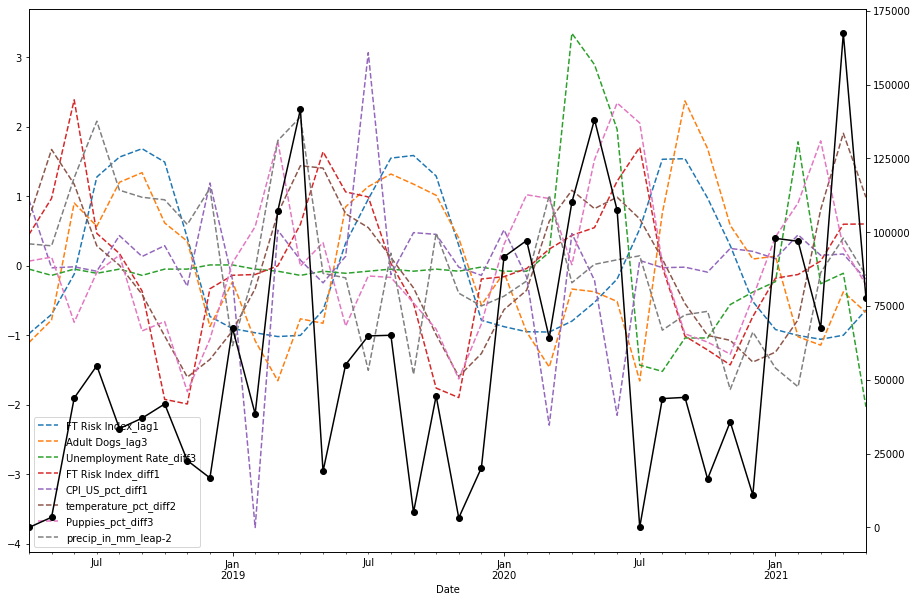

In [76]:
### FRONTLINE PLUS DOG L 3 PIP X 1
sku = '150848'

# ftl_gold_sku =[str(x) for x in list(mapping[mapping['product_desc'].apply(lambda x: 'FTL GOLD' in x)]['gsku'].values)]
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month
annual_stack = df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku]
annual_stack.plot(figsize=(15,10))
annual_stack.to_csv('C:\\Users\\qintong\\Desktop\\Pet GTN Forecast\\Working Folder\\result\\Frontline\\' + sku + '_annual' + '.csv')
df_all = df_all.dropna()
df_all.index.freq = 'MS'
DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]
lasso_est = DF_class.lasso_selection(sku, var_select)
var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)
Num_var = [  'FT Risk Index_lag1', 'Adult Dogs_lag3', 'Unemployment Rate_diff3', 'FT Risk Index_diff1', 'CPI_US_pct_diff1','temperature_pct_diff2', 'Puppies_pct_diff3', 'precip_in_mm_leap-2']
Dummy_var = ['1','2','8']

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')

df_all[Num_var].to_csv('C:\\Users\\qintong\\Desktop\\Pet GTN Forecast\\Working Folder\\result\\Frontline\\' + sku + '_external_select' + '.csv')

# est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
# print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])
# print(sku)
# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

In [77]:
result = pd.DataFrame(summary.tables[1])

Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['temperature', 'disposable_income_pct_lag2', 'disposable_income_pct_lag3', 'Unemployment Rate_lag1', 'humidity_lag1', 'humidity_lag3', 'FT Risk Index_lag1', 'Puppies_lag2', 'Adult Dogs_lag2', 'Adult Dogs_lag3', 'HW Risk Index_diff1', 'disposable_income_pct_pct_diff1', 'Unemployment Rate_pct_diff3', 'CPI_US_pct_diff1', 'CPI_US_pct_diff2', 'precip_in_mm_pct_diff1', 'Puppies_pct_diff3', 'Adult Dogs_pct_diff1', 'temperature_ma1', 'precip_in_mm_leap-2', 'precip_in_mm_leap-3', '

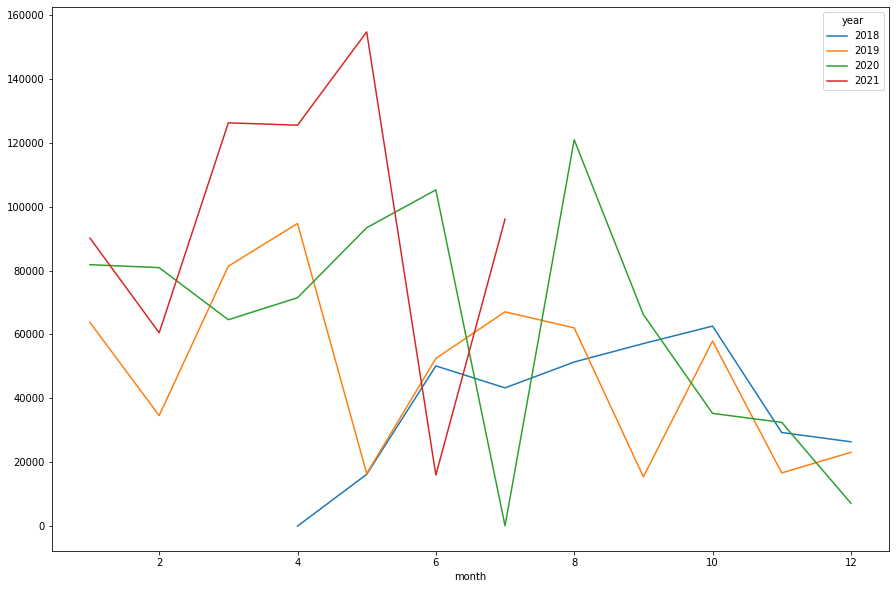

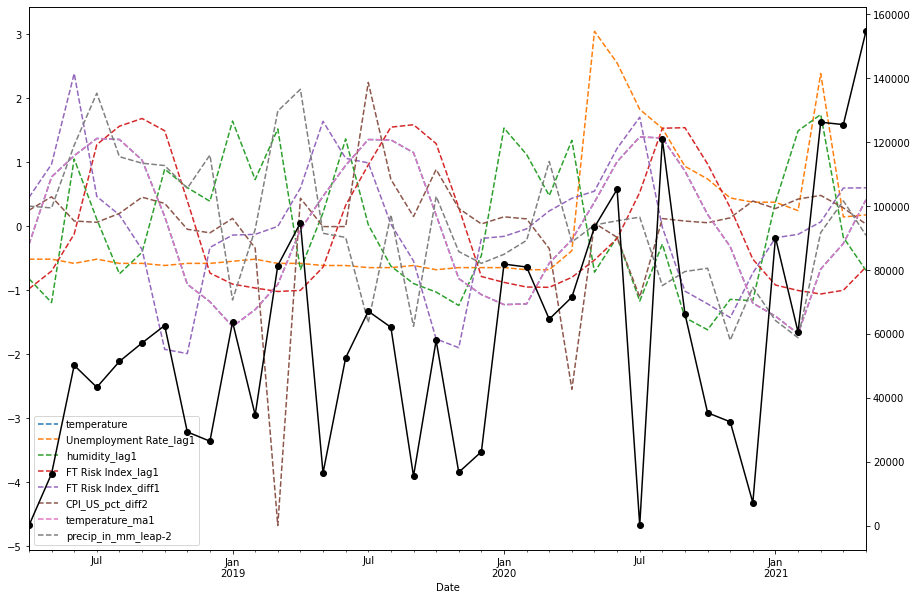

In [78]:
#FRONTLINE PLUS CAT 3 PIP X 1
sku = '150843'
# ftl_gold_sku =[str(x) for x in list(mapping[mapping['product_desc'].apply(lambda x: 'FTL GOLD' in x)]['gsku'].values)]
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month
df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku].plot(figsize=(15,10))
df_all = df_all.dropna()
df_all.index.freq = 'MS'

DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]


lasso_est = DF_class.lasso_selection(sku, var_select)

var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)


# ax.set_ylabel('size')

# ax2 = ax1.twinx()
# ax2.plot(df_all[['Adult Dogs']])

Num_var = ['temperature', 'Unemployment Rate_lag1', 'humidity_lag1',  'FT Risk Index_lag1',  'FT Risk Index_diff1', 'CPI_US_pct_diff2',  'temperature_ma1', 'precip_in_mm_leap-2']
Dummy_var = ['1','2','8']

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')


est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


# est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
# summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
# print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])

# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

In [79]:
result = pd.concat([result, pd.DataFrame(summary.tables[1])])

In [80]:
result

,0,1,2,3,4,5,6
0,,coef,std err,z,P>|z|,[0.025,0.975]
1,const,5.385e+04,3672.811,14.662,0.000,4.67e+04,6.11e+04
2,FT Risk Index_lag1,-2.736e+04,8308.710,-3.293,0.001,-4.36e+04,-1.11e+04
3,Adult Dogs_lag3,2.566e+04,8118.040,3.161,0.002,9753.655,4.16e+04
4,Unemployment Rate_diff3,9257.2511,3612.640,2.562,0.010,2176.608,1.63e+04
5,FT Risk Index_diff1,-2.656e+04,8359.337,-3.177,0.001,-4.29e+04,-1.02e+04
6,CPI_US_pct_diff1,8867.9434,9023.706,0.983,0.326,-8818.195,2.66e+04
7,temperature_pct_diff2,3.283e+04,7361.308,4.460,0.000,1.84e+04,4.73e+04
8,Puppies_pct_diff3,2.222e+04,1.05e+04,2.123,0.034,1702.149,4.27e+04
9,precip_in_mm_leap-2,6583.2495,2954.967,2.228,0.026,791.620,1.24e+04


Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['humidity_lag1', 'Adult Cats_lag3', 'Unemployment Rate_diff2', 'CPI_US_pct_diff2', 'HW Risk Index_pct_diff2', 'HW Risk Index_pct_diff3', 'Puppies_pct_diff3', 'humidity_leap-1', 'precip_in_mm_leap-2', '1', '2', '3', '7', '12']
****************************
[(0, 0, 1), (0, 0, 0, 12)]
SARIMAX Model:  0.38334561457270444


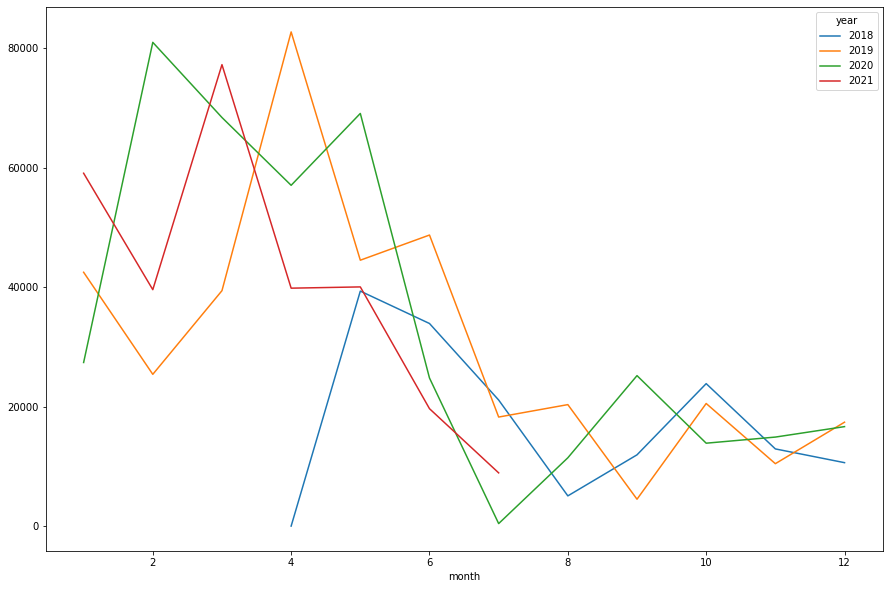

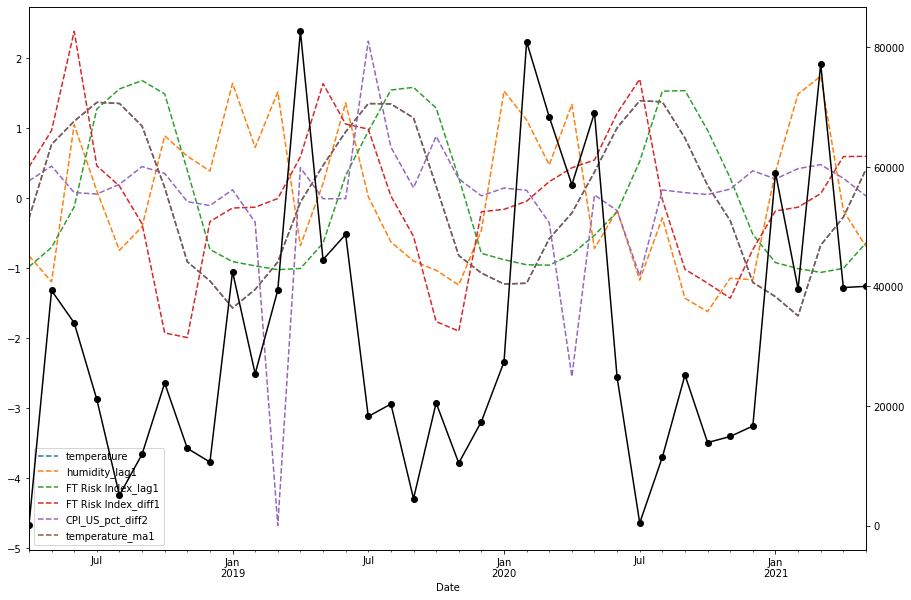

In [81]:
# FRONTLINE PLUS DOG L 6 PIP X 1
sku = '150849'
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month
df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku].plot(figsize=(15,10))
df_all = df_all.dropna()
df_all.index.freq = 'MS'

DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]


lasso_est = DF_class.lasso_selection(sku, var_select)

var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)


# ax.set_ylabel('size')

# ax2 = ax1.twinx()
# ax2.plot(df_all[['Adult Dogs']])

Num_var = ['temperature',  'humidity_lag1',  'FT Risk Index_lag1',  'FT Risk Index_diff1', 'CPI_US_pct_diff2',  'temperature_ma1']
Dummy_var = ['2','3']

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')

# est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
# print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))
result = pd.concat([result, pd.DataFrame(summary.tables[1])])
# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])

# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['disposable_income_pct_lag2', 'Kittens_lag3', 'Adult Cats_lag2', 'Unemployment Rate_diff2', 'CPI_US_pct_diff1', 'CPI_US_pct_diff2', 'temperature_pct_diff2', 'Puppies_pct_diff3', 'Kittens_pct_diff1', 'humidity_leap-1', 'precip_in_mm_leap-2', '2', '5', '10', '11']
OLS Model:  0.5982970035087487


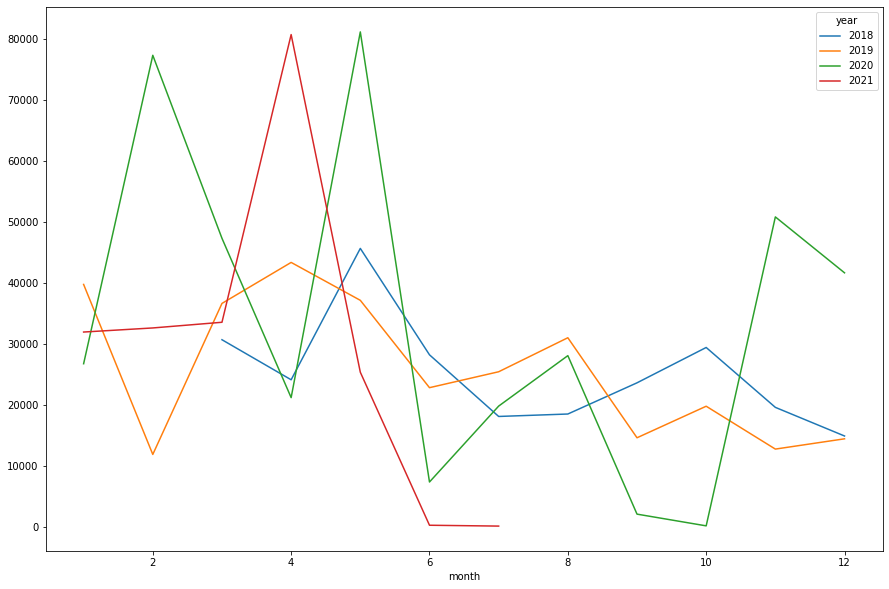

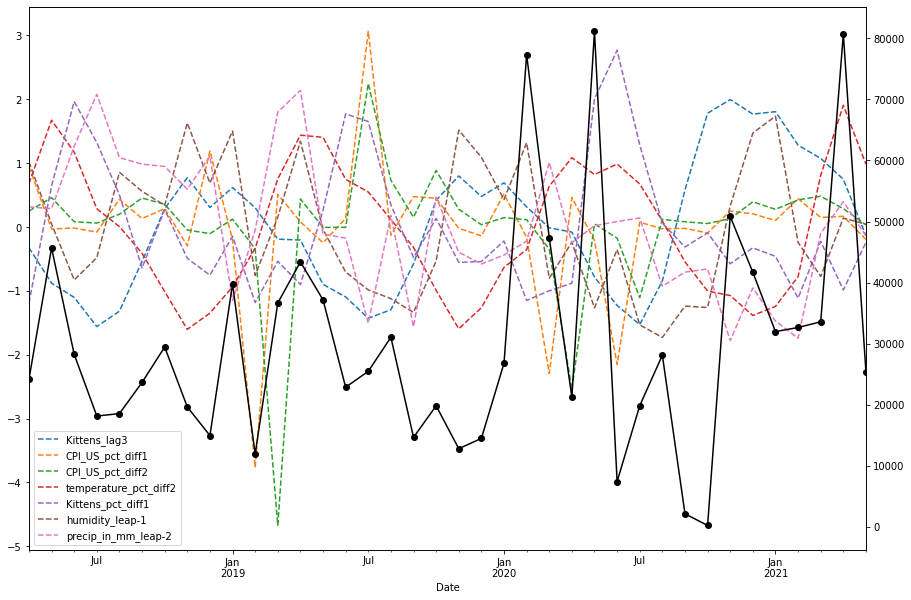

In [82]:
# FRONTLINE PLUS CAT 6 PIP X 1
sku = '150842'
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month
df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku].plot(figsize=(15,10))
df_all = df_all.dropna()
df_all.index.freq = 'MS'

DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]


lasso_est = DF_class.lasso_selection(sku, var_select)

var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)


# ax.set_ylabel('size')

# ax2 = ax1.twinx()
# ax2.plot(df_all[['Adult Dogs']])

Num_var = ['Kittens_lag3',  'CPI_US_pct_diff1', 'CPI_US_pct_diff2', 'temperature_pct_diff2',  'Kittens_pct_diff1', 'humidity_leap-1', 'precip_in_mm_leap-2']
Dummy_var = ['2', '5', '10', '11']

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')

est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))
result = pd.concat([result, pd.DataFrame(summary.tables[1])])
# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


# est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
# summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
# print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])

# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['disposable_income_pct_lag2', 'disposable_income_pct_lag3', 'humidity_lag1', 'humidity_lag3', 'Puppies_lag1', 'Adult Dogs_lag3', 'HW Risk Index_diff1', 'humidity_diff2', 'disposable_income_pct_pct_diff1', 'Unemployment Rate_pct_diff3', 'CPI_US_pct_diff1', 'CPI_US_pct_diff2', 'Puppies_pct_diff3', 'Adult Dogs_pct_diff1', 'precip_in_mm_leap-2', '2', '3', '8', '11']
OLS Model:  0.2793677322446702


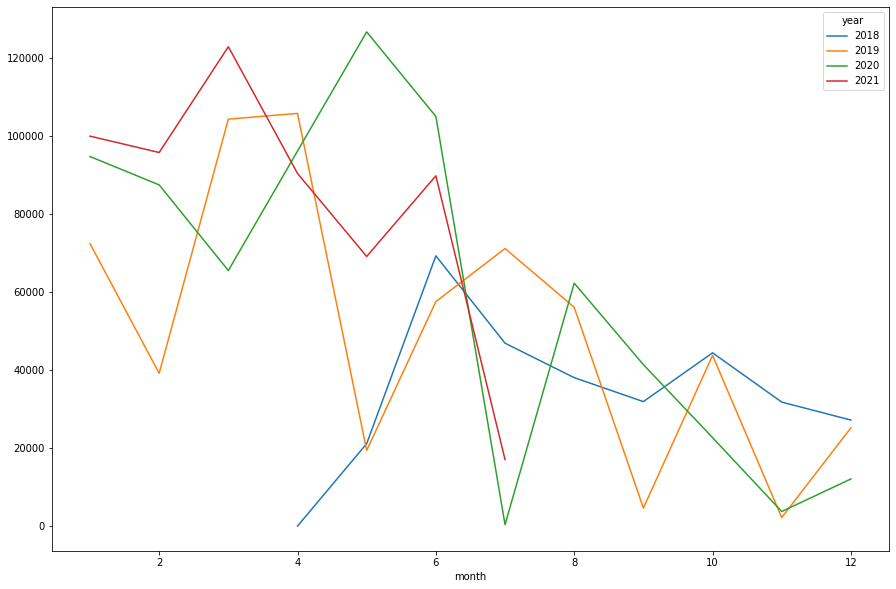

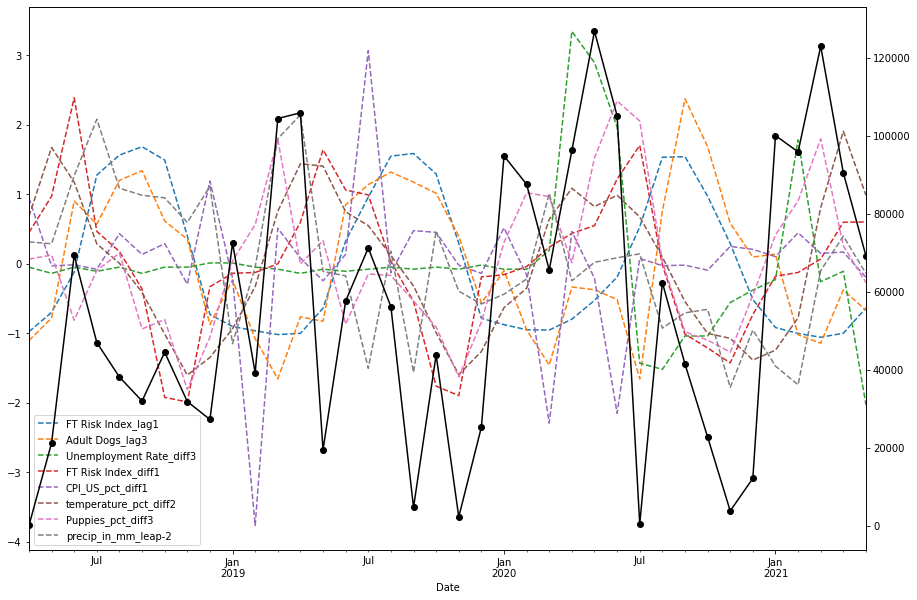

In [84]:
# FRONTLINE PLUS DOG S 3 PIP X 1
sku = '150844'
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month

annual_stack = df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku]
annual_stack.plot(figsize=(15,10))

annual_stack.to_csv('C:\\Users\\qintong\\Desktop\\Pet GTN Forecast\\Working Folder\\result\\Frontline\\' + sku + '_annual' + '.csv')
df_all = df_all.dropna()
df_all.index.freq = 'MS'

DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]


lasso_est = DF_class.lasso_selection(sku, var_select)

var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)


# ax.set_ylabel('size')

# ax2 = ax1.twinx()
# ax2.plot(df_all[['Adult Dogs']])

Num_var = [  'FT Risk Index_lag1', 'Adult Dogs_lag3', 'Unemployment Rate_diff3', 'FT Risk Index_diff1', 'CPI_US_pct_diff1','temperature_pct_diff2', 'Puppies_pct_diff3', 'precip_in_mm_leap-2']
Dummy_var = []

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')


est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))
result = pd.concat([result, pd.DataFrame(summary.tables[1])])
# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


# est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
# summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
# print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])

# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['Unemployment Rate_lag1', 'humidity_lag1', 'Adult Cats_lag2', 'humidity_diff3', 'Adult Dogs_diff1', 'disposable_income_pct_pct_diff1', 'Unemployment Rate_pct_diff2', 'CPI_US_pct_diff2', 'HW Risk Index_pct_diff2', 'Adult Dogs_pct_diff1', 'humidity_leap-1', 'precip_in_mm_leap-2', '1', '2', '3', '8', '9']
OLS Model:  1.385920656328959


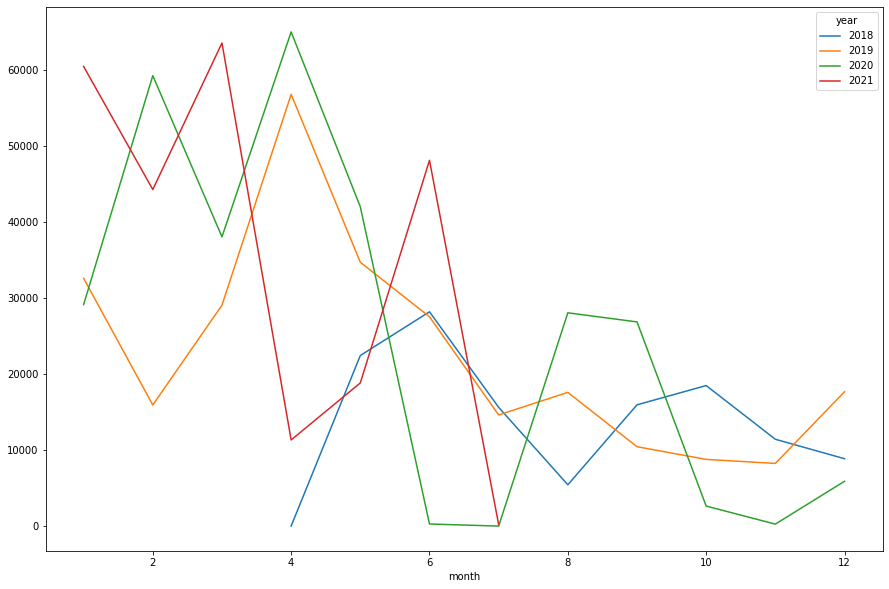

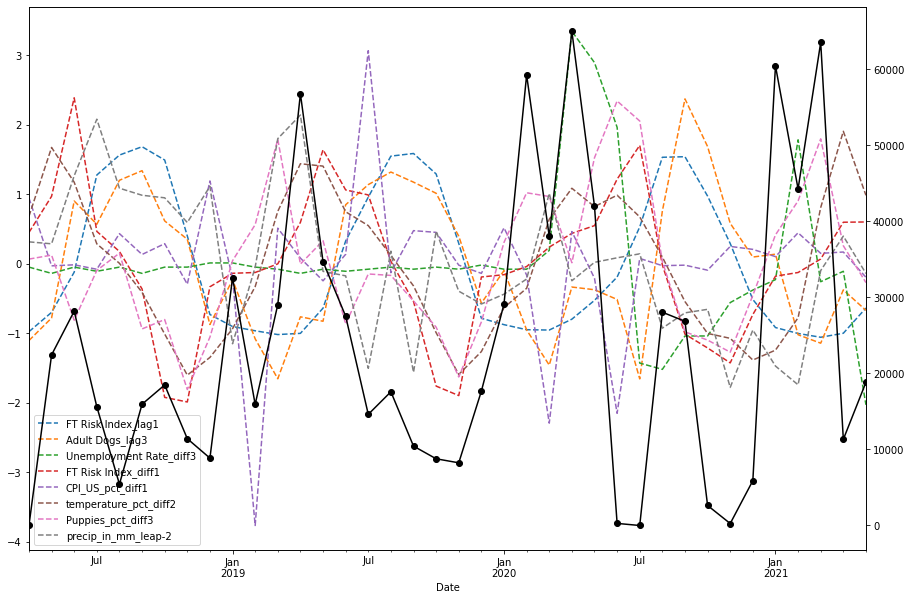

In [85]:
#### Done ####
### FRONTLINE PLUS DOG S 6 PIP X 1 ###
sku = '150845'
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month
df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku].plot(figsize=(15,10))
df_all = df_all.dropna()
df_all.index.freq = 'MS'

DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]


lasso_est = DF_class.lasso_selection(sku, var_select)

var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)


# ax.set_ylabel('size')

# ax2 = ax1.twinx()
# ax2.plot(df_all[['Adult Dogs']])


Num_var = [  'FT Risk Index_lag1', 'Adult Dogs_lag3', 'Unemployment Rate_diff3', 'FT Risk Index_diff1', 'CPI_US_pct_diff1','temperature_pct_diff2', 'Puppies_pct_diff3', 'precip_in_mm_leap-2']
Dummy_var = ['1','2','8']

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')


est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))
result = pd.concat([result, pd.DataFrame(summary.tables[1])])

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


# est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
# summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
# print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])

# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

Lasso on Total
Index(['disposable_income_pct', 'Unemployment Rate', 'CPI_US', 'HW Risk Index',
       'temperature', 'humidity', 'precip_in_mm', 'FT Risk Index', 'Puppies',
       'Adult Dogs',
       ...
       'temperature_leap-3', 'humidity_leap-1', 'humidity_leap-2',
       'humidity_leap-3', 'precip_in_mm_leap-1', 'precip_in_mm_leap-2',
       'precip_in_mm_leap-3', 'FT Risk Index_leap-1', 'FT Risk Index_leap-2',
       'FT Risk Index_leap-3'],
      dtype='object', length=171)
Lasso on Partial
final variables: ['disposable_income_pct_lag2', 'disposable_income_pct_lag3', 'humidity_lag1', 'humidity_lag3', 'Puppies_lag1', 'Adult Dogs_lag3', 'Adult Cats_lag3', 'Unemployment Rate_diff2', 'temperature_diff2', 'humidity_diff2', 'Adult Dogs_diff1', 'CPI_US_pct_diff1', 'CPI_US_pct_diff2', 'HW Risk Index_pct_diff2', 'Adult Dogs_pct_diff1', 'humidity_leap-1', '1', '2', '8', '11']
****************************
[(0, 0, 0), (1, 0, 0, 12)]
SARIMAX Model:  0.23653720073328222


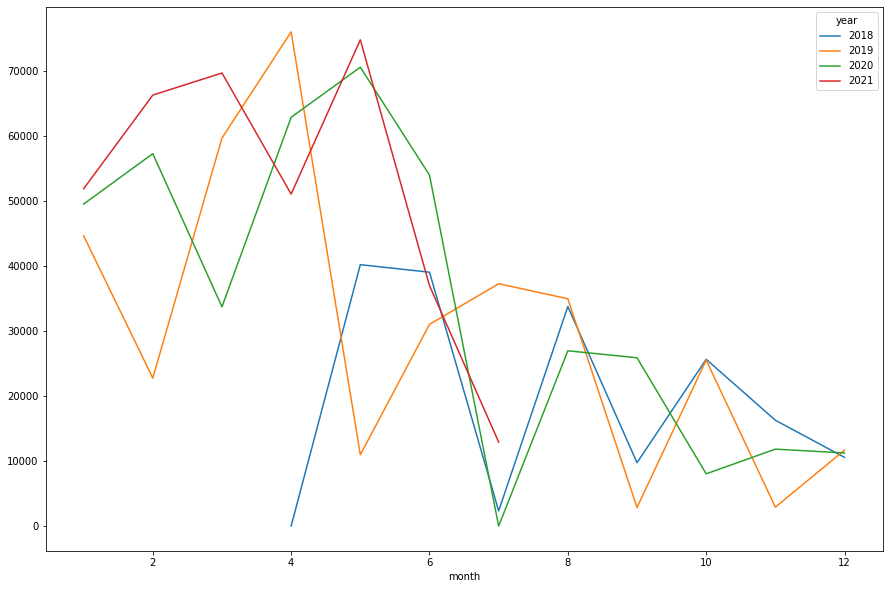

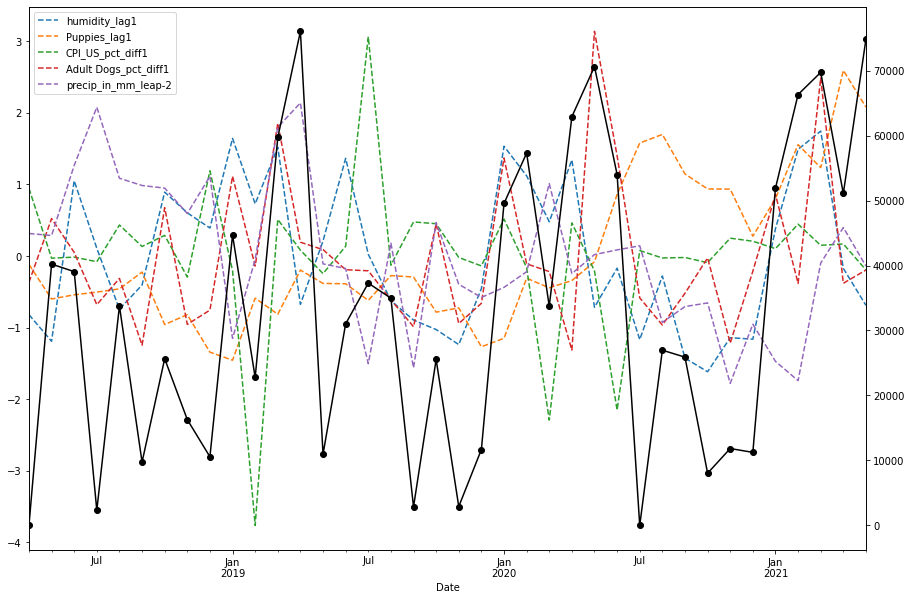

In [86]:
#### Done ####
sku = '150847'
df_revenue = Frontline_invoice[[sku]]
df_all = df_revenue.merge(external_var, on = ['Date'], how = 'outer')
df_all = df_all.set_index('Date')
df_train = df_all[df_all.index.year <= 2020]
df_forecast = df_all[df_all.index.year > 2020]
df_revenue_copy = df_revenue.copy()
df_revenue_copy['year'] = df_revenue_copy.index.year
df_revenue_copy['month'] = df_revenue_copy.index.month
df_revenue_copy.pivot_table(index = ['month'], columns = ['year'])[sku].plot(figsize=(15,10))
df_all = df_all.dropna()
df_all.index.freq = 'MS'

DF_class = Demand_Forecast(df_all, ext_var_list, '2018-06-01')
lasso_est = DF_class.lasso_selection(sku)
# print(var_select)
var_select = list(lasso_est.pvalues.index[1:]) + [str(x) for x in range(1,13)]


lasso_est = DF_class.lasso_selection(sku, var_select)

var_select = list(lasso_est.pvalues.index[1:]) 
print('final variables:', var_select)


# ax.set_ylabel('size')

# ax2 = ax1.twinx()
# ax2.plot(df_all[['Adult Dogs']])

Num_var = ['humidity_lag1', 'Puppies_lag1',  'CPI_US_pct_diff1',  'Adult Dogs_pct_diff1', 'precip_in_mm_leap-2']
Dummy_var = []

var_select = Num_var + Dummy_var

df_all.plot(y=Num_var, figsize = (15, 10), style = '--')
ax = df_all[sku].plot(secondary_y=True, color='k', marker='o')


# est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', '2020-12-01', 5)
# print('OLS Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))

# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     est, summary, Insample, forecast = DF_class.linear_regression(sku, var_select, '2018-06-01', end, 3)
#     rolling_forecast.append(forecast[2])

# print('OLS 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))


est = DF_class.ARIMAX_regression_training(sku, var_select, '2018-06-01', '2020-12-01', vanilla = [3, 0, 1] , seasonal = [2, 0, 0, 12])
summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', '2020-12-01', est, 5)
print('SARIMAX Model: ', np.average(abs((forecast - df_all['2021-01-01': '2021-05-01'][sku].values)/df_all['2021-01-01': '2021-05-01'][sku]).values))
result = pd.concat([result, pd.DataFrame(summary.tables[1])])
# forecast_time = ['2020-10-01', '2020-11-01','2020-12-01','2021-01-01', '2021-02-01']
# rolling_forecast = []
# for end in forecast_time:
#     summary, Insample, forecast = DF_class.ARIMAX_regression(sku, var_select, '2018-06-01', end, est, 3)
#     rolling_forecast.append(forecast[2])

# print('ARIMAX 3 month rolling:',np.average(abs(df_all['2021-01-01': '2021-05-01'][sku].values - np.asarray(rolling_forecast))/df_all['2021-01-01': '2021-05-01'][sku].values))

In [88]:
result.to_csv('C:\\Users\\qintong\\Desktop\\Pet GTN Forecast\\Working Folder\\result\\Frontline\\frontline_estimation.csv')